In [3]:
import numpy as np
import pandas as pd
from scipy import interpolate
import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload

import citrus_utils as vitaminC
import SphereSiZer as sszr

In [21]:
footpoints = 'geocentric'
tissue_src = '../preproc/tissue/'
oil_src = '../preproc/oil/'
#bname = 'C02_CRC3919_18A-24-1'
#bname = 'M01_CRC3226_12B-27-1'
#bname = 'M04_CRC3752_12B-28-7'
#bname = 'M09_CRC3816_12B-24-11'
bname = 'P01C_CRC3781_12A-31-9'
#bname = 'SR01_CRC3289_12B-19-9'
#bname = 'SR04_CRC2717_12B-40-1'
#bname = 'SW01_CRC3030_12B-8-5'
#bname = 'WR02_CRC3877_12B-44-13'
#bname = 'WR08_CRC3661_18B-16-5'
#bname = 'WR09_CRC3469_12B-36-9'
#bname = 'WR19_CRC3842_18B-18-5'
L = 0

lname = 'L{:02d}'.format(L)
oil_dst = oil_src + bname + '/' + lname + '/'
filename = oil_dst + bname + '_' + lname + '_' + footpoints + '.csv'
geodetic = np.loadtxt(filename, delimiter=',').T
N_0 = vitaminC.ellipsoid(*geodetic[:2],1,1,1)

In [22]:
q = sszr.BSquantile(N_0, b=25)
print(q)

0.0007463525547700748


```
bname = 'C02_CRC3919_18A-24-1'
L = 0
q = 0.0010109746299076935

bname = 'M01_CRC3226_12B-27-1'
L = 0
q = 0.0008320116259851666

bname = 'P01C_CRC3781_12A-31-9'
L = 0
q = 0.0007463525547700748

bname = 'SR01_CRC3289_12B-19-9'
L = 0
q = 0.0019457303512615467

bname = 'SW01_CRC3030_12B-8-5'
L = 0
q = 0.0007099014419414427

bname = 'WR02_CRC3877_12B-44-13'
L = 0
q = 0.001151889390145299

bname = 'WR08_CRC3661_18B-16-5'
L = 0
q = 0.001962635750414297

bname = 'WR19_CRC3842_18B-18-5'
L = 0
q = 0.0008690080525624722
```

In [23]:
k = 15.07183 # C02 L0
#k = 34.15 # M01 L0
k = 13.23218 # P01C
#k = 33.09992 # SR01 L0
#k = 20.99131 # SW01 L0
#k = 49.4825 #WR02 L0
#k = 186.426 #WR08 L0
#k = 31.70284 # WR19 L0

m = 3000;
X = sszr.gridSPH(m,3);
fhat = sszr.ske(X, N_0, k=k)
fhat = fhat.squeeze()

X_0 = sszr.gridSPH(1000,3);
nabla_g, SDhat = sszr.GskeSD(X_0, N_0, k)
nabla_g = nabla_g.squeeze()
SDhat = SDhat.squeeze()

In [24]:
NN_0 = N_0[:, N_0[2] > 0]
SN_0 = N_0[:, N_0[2] < 0]

In [25]:
q = 0.0010109746299076935
qind = np.sum((nabla_g/SDhat.reshape(-1,1))**2, axis=0) > q

Nmx, NZq, Nlamb, Narrlamb = sszr.contour_hemisphere(X, fhat, X_0, nabla_g, qind, hemisphere = 1)
Smx, SZq, Slamb, Sarrlamb = sszr.contour_hemisphere(X, fhat, X_0, nabla_g, qind, hemisphere = 2)

theta = np.linspace(0, 2*np.pi, 1000)

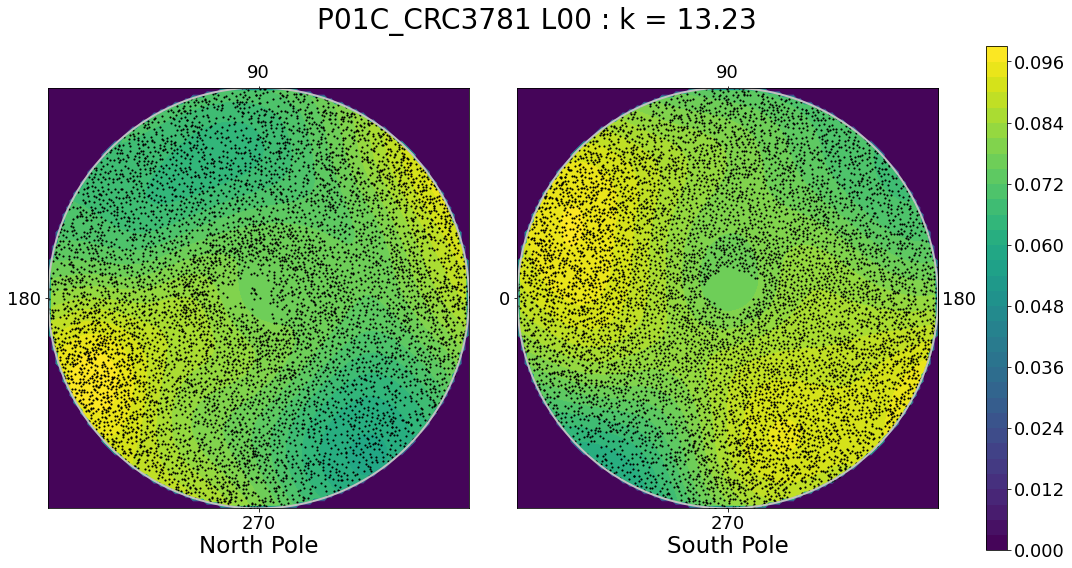

In [26]:
fs = 18
lvls = 32
fig, ax = plt.subplots(1, 3, figsize=(15,8), gridspec_kw={"width_ratios":[1,1, 0.05]})

for i in [0,1]:
    ax[i].set_aspect('equal')
    ax[i].plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), c='silver', lw=2);
    ax[i].tick_params(labelsize=fs)
    ax[i].set_xticks(ticks = [0])
    ax[i].set_yticks(ticks = [0])
    ax[i].set_xticklabels(labels = ['270'])
    
    ax_t = ax[i].secondary_xaxis('top')
    ax_t.tick_params(axis='x', direction='inout', labelsize=fs)
    ax_t.set_xticks(ticks = [0])
    ax_t.set_xticklabels(labels = ['90'])
    
i = 0
cs = ax[i].contourf(Nmx,Nmx, NZq, levels=lvls, vmax=fhat.max())
ax[i].scatter(*sszr.lambPROJ(NN_0, 1), marker='.', color='k', s=5)
Qq = ax[i].quiver(*Nlamb, *Narrlamb, color='r', scale_units='width')#, scale=10)
Qq._init()
assert isinstance(Qq.scale, float)
ax[i].set_title('North Pole', fontsize=fs+5, y=-0.12)
ax[i].set_yticklabels(labels = ['180'])

i = 1
cs = ax[i].contourf(-Smx, Smx, SZq, levels=lvls, vmax=fhat.max())
foo = sszr.lambPROJ(SN_0, 2)
ax[i].scatter(-foo[0], foo[1], marker='.', color='k', s=5)
ax[i].quiver(-Slamb[0], Slamb[1], -Sarrlamb[0], Sarrlamb[1], color='r', scale=Qq.scale, scale_units='width');
ax[i].tick_params( direction = 'out' )
ax_r = ax[i].secondary_yaxis('right')
ax_r.tick_params(axis='y', direction='in', labelsize=fs)
ax_r.set_yticks(ticks = [0])
ax_r.set_yticklabels(labels = ['180'])
ax[i].set_title('South Pole', fontsize=fs+5, y=-0.12)

clb = fig.colorbar(cs, cax=ax[2], shrink=0.25, fraction=0.9);
clb.ax.tick_params(labelsize=fs) 

title = '_'.join(bname.split('_')[:2]) + ' ' + lname + ' : k = {:.2f}'.format(k)
fig.suptitle(title, fontsize=fs+10)

fig.tight_layout();

filename = oil_dst + bname + '_' + lname + '_emi_kde_N'
fig.savefig(filename + '.jpg', dpi=100, format='jpg')#, pil_kwargs={'optimize':True})

In [27]:
rot = np.zeros((3,3))
#rot = np.identity(3)
#rot[1,1] = 1; rot[2,0] = 1; rot[0,2] = 1
rot[0,0] = 1; rot[1,2] = 1; rot[2,1]= -1;

Wmx, WZq, Wlamb, Warrlamb = sszr.contour_hemisphere(rot@X, fhat, rot@X_0, rot@nabla_g, qind, hemisphere = 1)
Emx, EZq, Elamb, Earrlamb = sszr.contour_hemisphere(rot@X, fhat, rot@X_0, rot@nabla_g, qind, hemisphere = 2)

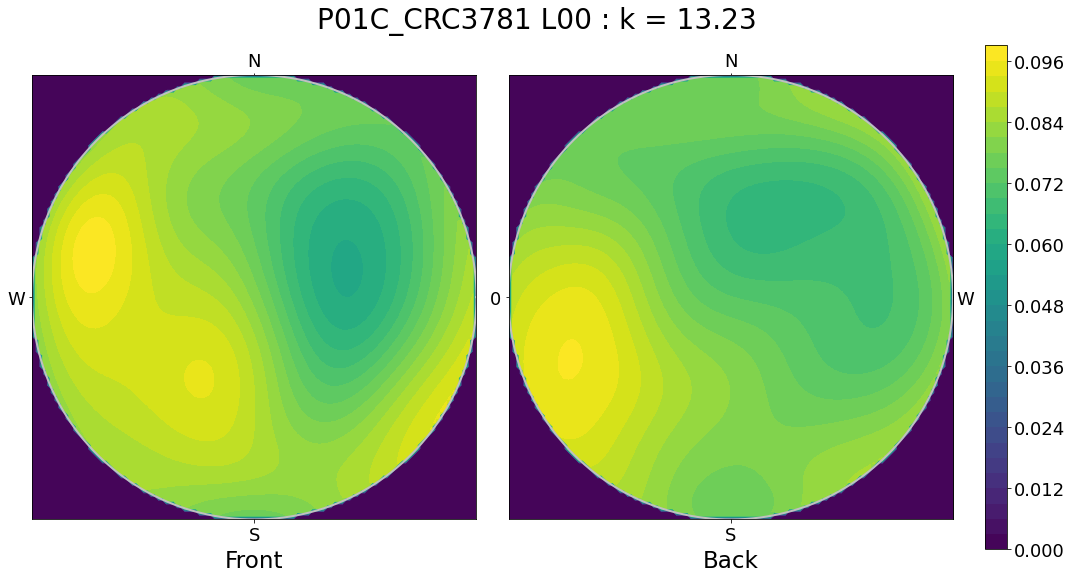

In [28]:
fs = 18
fig, ax = plt.subplots(1, 3, figsize=(15,8), gridspec_kw={"width_ratios":[1,1, 0.05]})

for i in [0,1]:
    ax[i].set_aspect('equal')
    ax[i].plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), c='silver', lw=2);
    ax[i].tick_params(labelsize=fs)
    ax[i].set_xticks(ticks = [0])
    ax[i].set_yticks(ticks = [0])
    ax[i].set_xticklabels(labels = ['S'])
    
    ax_t = ax[i].secondary_xaxis('top')
    ax_t.tick_params(axis='x', direction='inout', labelsize=fs)
    ax_t.set_xticks(ticks = [0])
    ax_t.set_xticklabels(labels = ['N'])
    
i = 0
cs = ax[i].contourf(Wmx,Wmx, WZq, levels=lvls, vmax=fhat.max())
#ax[i].scatter(*Nlamb, marker='x', color='r')
Qq = ax[i].quiver(*Wlamb, *Warrlamb, color='r', scale_units='width')#, scale=13)
Qq._init()
assert isinstance(Qq.scale, float)

ax[i].set_title('Front', fontsize=fs+5, y=-0.12)
ax[i].set_yticklabels(labels = ['W'])

i = 1
cs = ax[i].contourf(-Emx, Emx, EZq, levels=lvls, vmax=fhat.max())
ax[i].quiver(-Elamb[0], Elamb[1], -Earrlamb[0], Earrlamb[1], color='r', scale=Qq.scale, scale_units='width');
ax[i].tick_params( direction = 'out' )
ax_r = ax[i].secondary_yaxis('right')
ax_r.tick_params(axis='y', direction='in', labelsize=fs)
ax_r.set_yticks(ticks = [0])
ax_r.set_yticklabels(labels = ['W'])
ax[i].set_title('Back', fontsize=fs+5, y=-0.12)

clb = fig.colorbar(cs, cax=ax[2], shrink=0.25, fraction=0.9);
clb.ax.tick_params(labelsize=fs) 

fig.suptitle(title, fontsize=fs+10)

fig.tight_layout();

filename = oil_dst + bname + '_' + lname + '_emi_kde_W'
fig.savefig(filename + '.jpg', dpi=100, format='jpg', pil_kwargs={'optimize':True})

# SphereSiZer

In [29]:
k = np.linspace(5, 100, 20)
m = 3000;
X = sszr.gridSPH(m,3);
fhat = sszr.ske(X, N_0, k=k)

X_0 = sszr.gridSPH(1000,3);
nabla_g, SDhat = sszr.GskeSD(X_0, N_0, k)
nabla_g = nabla_g.squeeze()
SDhat = SDhat.squeeze()

In [30]:
qind = np.sum((nabla_g/(SDhat.T)[..., np.newaxis])**2, axis=1) > q
theta = np.linspace(0, 2*np.pi, 1000)

rot = np.zeros((3,3))
#rot = np.identity(3)
#rot[1,1] = 1; rot[2,0] = 1; rot[0,2] = 1
rot[0,0] = 1; rot[1,2] = 1; rot[2,1]= -1;

rotX = rot@X
rotX_0 = rot@X_0

for i in range(len(k)):
    Nmx, NZq, Nlamb, Narrlamb = sszr.contour_hemisphere(X, fhat[i], X_0, nabla_g[i], qind[i], hemisphere = 1)
    Smx, SZq, Slamb, Sarrlamb = sszr.contour_hemisphere(X, fhat[i], X_0, nabla_g[i], qind[i], hemisphere = 2)
    
    fs = 18; lvls = 32
    filename = oil_dst + 'N_k{0:03d}_'.format(i) + bname + '_' + lname + '_kde'
    lambert_plot_Z(k[i], fs=fs, lvls=lvls, writefig=True, filename=filename)
    
    rotnabla_g = rot@(nabla_g[i])
    
    filename = oil_dst + 'W_k{0:03d}_'.format(i) + bname + '_' + lname + '_kde'
    
    Wmx, WZq, Wlamb, Warrlamb = sszr.contour_hemisphere(rotX, fhat[i], rotX_0, rotnabla_g, qind[i], hemisphere = 1)
    Emx, EZq, Elamb, Earrlamb = sszr.contour_hemisphere(rotX, fhat[i], rotX_0, rotnabla_g, qind[i], hemisphere = 2)
    lambert_plot_X(k[i], fs=fs, lvls=lvls, writefig=True, filename=filename)

In [19]:
def lambert_plot_Z(k, fs = 18, lvls = 12, writefig=False, filename='file'):

    fig, ax = plt.subplots(1, 3, figsize=(15,8), gridspec_kw={"width_ratios":[1,1, 0.05]})

    for i in [0,1]:
        ax[i].set_aspect('equal')
        ax[i].plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), c='silver', lw=2);
        ax[i].tick_params(labelsize=fs)
        ax[i].set_xticks(ticks = [0])
        ax[i].set_yticks(ticks = [0])
        ax[i].set_xticklabels(labels = ['270'])

        ax_t = ax[i].secondary_xaxis('top')
        ax_t.tick_params(axis='x', direction='inout', labelsize=fs)
        ax_t.set_xticks(ticks = [0])
        ax_t.set_xticklabels(labels = ['90'])

    i = 0
    cs = ax[i].contourf(Nmx,Nmx, NZq, levels=lvls, vmax=fhat.max())
    Qq = ax[i].quiver(*Nlamb, *Narrlamb, color='r', scale_units='width')#, scale=10)
    Qq._init()
    assert isinstance(Qq.scale, float)
    ax[i].set_title('North Pole', fontsize=fs+5, y=-0.12)
    ax[i].set_yticklabels(labels = ['180'])

    i = 1
    cs = ax[i].contourf(-Smx, Smx, SZq, levels=lvls, vmax=fhat.max())
    #ax[i].scatter(*Slamb, marker='x', color='r')
    ax[i].quiver(-Slamb[0], Slamb[1], -Sarrlamb[0], Sarrlamb[1], color='r', scale=Qq.scale, scale_units='width');
    ax[i].tick_params( direction = 'out' )
    ax_r = ax[i].secondary_yaxis('right')
    ax_r.tick_params(axis='y', direction='in', labelsize=fs)
    ax_r.set_yticks(ticks = [0])
    ax_r.set_yticklabels(labels = ['180'])
    ax[i].set_title('South Pole', fontsize=fs+5, y=-0.12)

    clb = fig.colorbar(cs, cax=ax[2], shrink=0.25, fraction=0.9);
    clb.ax.tick_params(labelsize=fs)

    title = '_'.join(bname.split('_')[:2]) + ' ' + lname + ' : k = {:.2f}'.format(k)
    fig.suptitle(title, fontsize=fs+10)

    fig.tight_layout();

    if writefig:
        #filename = oil_dst + bname + '_' + lname + '_emi_kde_N'
        fig.savefig(filename + '.jpg', dpi=72, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')
        plt.close()

def lambert_plot_X(k, fs=18, lvls=12, writefig=False, filename='file'):

    fig, ax = plt.subplots(1, 3, figsize=(15,8), gridspec_kw={"width_ratios":[1,1, 0.05]})

    for i in [0,1]:
        ax[i].set_aspect('equal')
        ax[i].plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), c='silver', lw=2);
        ax[i].tick_params(labelsize=fs)
        ax[i].set_xticks(ticks = [0])
        ax[i].set_yticks(ticks = [0])
        ax[i].set_xticklabels(labels = ['S'])

        ax_t = ax[i].secondary_xaxis('top')
        ax_t.tick_params(axis='x', direction='inout', labelsize=fs)
        ax_t.set_xticks(ticks = [0])
        ax_t.set_xticklabels(labels = ['N'])

    i = 0
    cs = ax[i].contourf(Wmx,Wmx, WZq, levels=lvls, vmax=fhat.max())
    #ax[i].scatter(*Nlamb, marker='x', color='r')
    Qq = ax[i].quiver(*Wlamb, *Warrlamb, color='r', scale_units='width')#, scale=13)
    Qq._init()
    assert isinstance(Qq.scale, float)

    ax[i].set_title('Front', fontsize=fs+5, y=-0.12)
    ax[i].set_yticklabels(labels = ['W'])

    i = 1
    cs = ax[i].contourf(-Emx, Emx, EZq, levels=lvls, vmax=fhat.max())
    ax[i].quiver(-Elamb[0], Elamb[1], -Earrlamb[0], Earrlamb[1], color='r', scale=Qq.scale, scale_units='width');
    ax[i].tick_params( direction = 'out' )
    ax_r = ax[i].secondary_yaxis('right')
    ax_r.tick_params(axis='y', direction='in', labelsize=fs)
    ax_r.set_yticks(ticks = [0])
    ax_r.set_yticklabels(labels = ['W'])
    ax[i].set_title('Back', fontsize=fs+5, y=-0.12)

    clb = fig.colorbar(cs, cax=ax[2], shrink=0.25, fraction=0.9);
    clb.ax.tick_params(labelsize=fs)

    title = '_'.join(bname.split('_')[:2]) + ' ' + lname + ' : k = {:.2f}'.format(k)
    fig.suptitle(title, fontsize=fs+10)

    fig.tight_layout();

    if writefig:
        #filename = oil_dst + bname + '_' + lname + '_emi_kde_W'
        fig.savefig(filename + '.jpg', dpi=72, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')
        plt.close();


In [ ]:
ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')

ax.scatter(*(rot@N_0), s=5, c='orange', alpha=0.2)
ax.quiver(*(rot@X_0), *(rot@nabla_g), normalize=True);

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

for a in ax:
    a.plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), '-k', lw=3)
    a.set_aspect('equal')
ax[0].scatter(*pslamb, c=Z, s=50, marker='o', cmap='viridis', vmin=0)
ax[1].scatter(*Lgrid[:, radii_mask], c=itrplt, s=10, cmap='viridis', vmax=Z.max(), vmin=0)

fig.tight_layout();

In [ ]:
Zq = np.zeros_like(Lgrid[0])
Zq[radii_mask] = itrplt
Zq = Zq.reshape(Lgrid[0].shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cs = ax.contourf(mx,mx, Zq, levels=12)
ax.plot(np.sqrt(2)*np.cos(theta), np.sqrt(2)*np.sin(theta), '-k', lw=4);
ax.scatter(*lamb, marker='x', color='r')
ax.quiver(*lamb, *arrlamb, color='r')#, scale=10)
ax.set_aspect('equal')
cbar = fig.colorbar(cs);

In [ ]:
X_0 = gridSPH(1000,3);
nabla_g, SDhat = GskeSD(X_0, N_0, k)
nabla_g = nabla_g.squeeze()
SDhat = SDhat.squeeze()

In [ ]:
q = 0.001151889390145299
qind = np.sum((nabla_g/SDhat.reshape(-1,1))**2, axis=0) > 1e-3
np.sum(qind)

In [ ]:
hemi_mask = X_0[2] > 0
signif_mask = hemi_mask & qind
Hemi = X_0[:, signif_mask]
rho = np.sqrt(2/(1+Hemi[2]))
rhox = rho*Hemi[0]
rhoy = rho*Hemi[1]
lamb = lambPROJ(Hemi,1)
Dg = nabla_g[:, signif_mask]

In [ ]:
radii = np.sqrt(np.sum((Hemi + Dg)**2, axis=0))
arrowhead = (Hemi + Dg)/radii
arrlamb = lambPROJ(arrowhead,1)
arrlamb

In [ ]:
print(nabla_g.shape)
print(SDhat.shape)
print(Z.shape)
print(np.sum(hemi_mask))
print(hemi_mask.shape)
print(qind.shape)
print(Dg.shape)

In [ ]:
rot

In [ ]:
X0 = X.copy()

X0 = rot @ X
hemi = X0[2] > 0
x,y,z = X0[:, hemi]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z, s=5)
ax.set_xlim((-1,1)); ax.set_ylim((-1,1)); ax.set_zlim((-1,1))
ax.set_xlabel('X Label');
ax.set_ylabel('Y Label');
ax.set_zlabel('Z Label');

In [ ]:
def contPLOT(N_0, k, pgX1, pgX2=None, pview=None):
    
    m = 60**2 + 1;
    if pgX2 is None:
        if np.sum(np.sign(N_0[2])) < 0:
            X = gridSPH(m,1);
        else:  
            X = gridSPH(m,2);

    else:
        X = gridSPH((m-1)/2,3);
    

    Z=ske(X(:,:,i), N_0, k);
    px=sqrt(p.^2./(1-X(:,3,i).^2)).*(X(:,1,i));
    py=sqrt(p.^2./(1-X(:,3,i).^2)).*(X(:,2,i));

    IP=scatteredInterpolant(px,py,Z);
    IP.ExtrapolationMethod = 'none';
    mx=linspace(-sqrt(2),sqrt(2),100);
    [Xq, Yq]=meshgrid(mx,mx);
    Zq(:,:,i)=IP(Xq,Yq);

    h1=subplot(1,m,1);
    hold on
    circles(0,0,sqrt(2),'color','black')
    colormap(gray)
    if nargin<5
        if signm>0
            contour(Xq,Yq,Zq(:,:,1),20,'fill','on')
            contNOTA(1)
        else
            contour(fliplr(Xq),Yq,Zq(:,:,1),20,'fill','on')
            contNOTA(2)
        end
    else
        if pview==1
            contour(Xq,Yq,Zq(:,:,1),20,'fill','on')
            contNOTA(6)
        elseif pview==2
            contour(Xq,Yq,Zq(:,:,1),20,'fill','on')
            contNOTA(4)
        end
    end
    set(gca,'YTickLabel',[],'ytick',[],'XTickLabel',[],'xtick',[], ...
       'box','off','visible','off') 
    
    as=quiver(signm*pgX1(:,1), pgX1(:,2), signm*(pgX1(:,3)-pgX1(:,1)), (pgX1(:,4)-pgX1(:,2)),0,'g-');
    

    if nargin>3
        h2=subplot(1,2,2);
        hold on
        circles(0,0,sqrt(2),'color','black')
        colormap(gray)
        contour(fliplr(Xq),Yq,Zq(:,:,2),20,'fill','on')
        set(gca,'YTickLabel',[],'ytick',[],'XTickLabel',[],'xtick',[], ...
           'box','off','visible','off')
        
        if nargin==4
            contNOTA(3)
        else
            if pview==1
                contNOTA(7)
            elseif pview==2
                contNOTA(5)
            end
        end
        
        quiver(-pgX2(:,1), pgX2(:,2), -(pgX2(:,3)-pgX2(:,1)), (pgX2(:,4)-pgX2(:,2)), ...
            as.AutoScaleFactor,'g-')

        
        p=get(h1,'pos');
        p(3)=0.45;
        p(1)=(1-2*p(3))/2;
        set(h1,'pos',p);
        p(1)=p(1)+p(3);
        set(h2,'pos',p)

In [ ]:
def SphereSizer(N_0, q, k_0, sph=2, pview=1)